## **Stain Normalization**
I have read some papers  about stain normalization of histology images and would like to share some functions that perform this transformation. The basic idea is to convert train and test images to the similar color space. Here is the list of papers describing this process:
- [Neural Stain Normalization and Unsupervised Classification of Cell Nuclei in Histopathological Breast Cancer Images](http://https://arxiv.org/abs/1811.03815)
- [The importance of stain normalization in colorectal tissue classification with convolutional networks](http://https://arxiv.org/abs/1702.05931)
- [Stain normalization of histopathology images using generative adversarial networks](http://https://ieeexplore.ieee.org/document/8363641)
-[ A Nonlinear Mapping Approach to Stain Normalization in Digital Histopathology Images Using Image-Specific Color Deconvolution](http://https://w3.mi.parisdescartes.fr/~lomn/Cours/CV/BME/HistoPatho/LongPapers/DestainingLong2014.pdf)
- [Automated Classification for Breast Cancer Histopathology Images: Is Stain Normalization Important?](http://https://www.springerprofessional.de/en/automated-classification-for-breast-cancer-histopathology-images/15030090)
- [A METHOD FOR NORMALIZING HISTOLOGY SLIDES FOR QUANTITATIVE ANALYSIS](http://http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf)




In [15]:
from sklearn.utils import shuffle
import pandas as pd
import os

# Save train labels to dataframe
df = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")

# Save test labels to dataframe
df_test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')

df = shuffle(df)

In [16]:
# True positive diagnosis
df_true_positive = df[df["label"] == 1]
print("True positive diagnosis: " + str(len(df_true_positive)))

# True negative diagnosis
df_true_negative = df[df["label"] == 0]
print("True negative diagnosis: " + str(len(df_true_negative)))

True positive diagnosis: 89117
True negative diagnosis: 130908


In [17]:
# Train List
train_list = df['id'].tolist()
train_list = ['../input/histopathologic-cancer-detection/train/'+ name + ".tif" for name in train_list]

# Test list
test_list = df_test['id'].tolist()
test_list = ['../input/histopathologic-cancer-detection/test/'+ name + ".tif" for name in test_list]


In [18]:
!pip install spams

You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
# STAIN NORMALIZATION FUNCTIONS
import spams
class TissueMaskException(Exception):
    pass

######################################################################################################

def is_uint8_image(I):

    if not is_image(I):
        return False
    if I.dtype != np.uint8:
        return False
    return True
######################################################################################################

def is_image(I):

    if not isinstance(I, np.ndarray):
        return False
    if not I.ndim == 3:
        return False
    return True
######################################################################################################

def get_tissue_mask(I, luminosity_threshold=0.8):

    I_LAB = cv.cvtColor(I, cv.COLOR_RGB2LAB)
    L = I_LAB[:, :, 0] / 255.0  # Convert to range [0,1].
    mask = L < luminosity_threshold

    # Check it's not empty
    if mask.sum() == 0:
        raise TissueMaskException("Empty tissue mask computed")

    return mask

######################################################################################################

def convert_RGB_to_OD(I):

    mask = (I == 0)
    I[mask] = 1
    

    #return np.maximum(-1 * np.log(I / 255), 1e-6)
    return np.maximum(-1 * np.log(I / 255), np.zeros(I.shape) + 0.1)

######################################################################################################

def convert_OD_to_RGB(OD):

    assert OD.min() >= 0, "Negative optical density."
    
    OD = np.maximum(OD, 1e-6)
    
    return (255 * np.exp(-1 * OD)).astype(np.uint8)

######################################################################################################

def normalize_matrix_rows(A):

    return A / np.linalg.norm(A, axis=1)[:, None]

######################################################################################################


def get_concentrations(I, stain_matrix, regularizer=0.01):

    OD = convert_RGB_to_OD(I).reshape((-1, 3))
    return spams.lasso(X=OD.T, D=stain_matrix.T, mode=2, lambda1=regularizer, pos=True).toarray().T

######################################################################################################

def get_stain_matrix(I, luminosity_threshold=0.8, angular_percentile=99):
    
    #assert is_uint8_image(I), "Image should be RGB uint8."
    # Convert to OD and ignore background
    tissue_mask = get_tissue_mask(I, luminosity_threshold=luminosity_threshold).reshape((-1,))
    OD = convert_RGB_to_OD(I).reshape((-1, 3))
    
    OD = OD[tissue_mask]

    # Eigenvectors of cov in OD space (orthogonal as cov symmetric)
    _, V = np.linalg.eigh(np.cov(OD, rowvar=False))

    # The two principle eigenvectors
    V = V[:, [2, 1]]

    # Make sure vectors are pointing the right way
    if V[0, 0] < 0: V[:, 0] *= -1
    if V[0, 1] < 0: V[:, 1] *= -1

    # Project on this basis.
    That = np.dot(OD, V)

    # Angular coordinates with repect to the prinicple, orthogonal eigenvectors
    phi = np.arctan2(That[:, 1], That[:, 0])

    # Min and max angles
    minPhi = np.percentile(phi, 100 - angular_percentile)
    maxPhi = np.percentile(phi, angular_percentile)

    # the two principle colors
    v1 = np.dot(V, np.array([np.cos(minPhi), np.sin(minPhi)]))
    v2 = np.dot(V, np.array([np.cos(maxPhi), np.sin(maxPhi)]))

    # Order of H and E.
    # H first row.
    if v1[0] > v2[0]:
        HE = np.array([v1, v2])
    else:
        HE = np.array([v2, v1])

    return normalize_matrix_rows(HE)

######################################################################################################

def mapping(target,source):
    
    stain_matrix_target = get_stain_matrix(target)
    target_concentrations = get_concentrations(target,stain_matrix_target)
    maxC_target = np.percentile(target_concentrations, 99, axis=0).reshape((1, 2))
    stain_matrix_target_RGB = convert_OD_to_RGB(stain_matrix_target) 
    
    stain_matrix_source = get_stain_matrix(source)
    source_concentrations = get_concentrations(source, stain_matrix_source)
    maxC_source = np.percentile(source_concentrations, 99, axis=0).reshape((1, 2))
    source_concentrations *= (maxC_target / maxC_source)
    tmp = 255 * np.exp(-1 * np.dot(source_concentrations, stain_matrix_target))
    return tmp.reshape(source.shape).astype(np.uint8)


Text(0.5,1,'Transformed Image')

<Figure size 432x288 with 0 Axes>

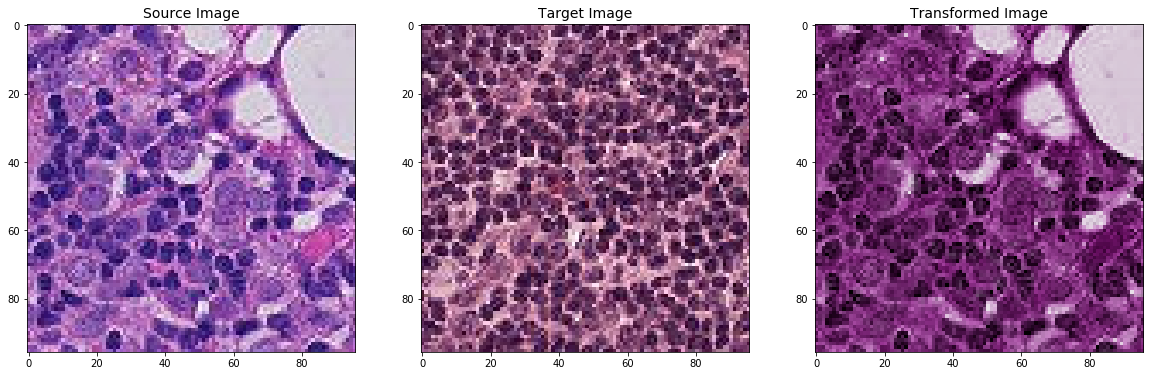

In [27]:
# Show example stain transformation
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

target = cv.imread(test_list[108])
source = cv.imread(train_list[555])

# Convert from cv2 standard of BGR to our convention of RGB.
target = cv.cvtColor(target, cv.COLOR_BGR2RGB)
source = cv.cvtColor(source, cv.COLOR_BGR2RGB)

# Perform stain normalization
transformed = mapping(target, source)

fig = plt.figure()
fig, ax = plt.subplots(1,3, figsize=(20,20))

ax[0].imshow(source)
ax[0].set_title("Source Image",fontsize=14)
ax[1].imshow(target)
ax[1].set_title("Target Image",fontsize=14)
ax[2].imshow(transformed)
ax[2].set_title("Transformed Image",fontsize=14)